In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import fminbound
from scipy.special import gammaln

### Data generation

In [2]:
s = np.random.normal(0,1,200)
sout = [8,8.75,9.5]
sall = np.concatenate([s,sout])
print(sall.shape)

(203,)


### Data Fitting with Gaussian, Laplacian and Student Distribution
One dimensional data is relatively easy to deal with. \
The Gaussian (Normal) distribution is given by,
$$\mathcal{N}(x;\mu,\sigma^2)\triangleq\frac{1}{\sqrt{2\pi\sigma^2}}exp\bigg(-\frac{1}{2}\frac{(x-\mu)^2}{\sigma^2}\bigg)$$
Its statistics (mean and standard deviation) is given by,
$$\mu = \frac{\sum^N_i x_i}{N} \text{and } \sigma = \sqrt{\frac{\sum^N_i (x_i-\mu)^2}{N}}$$

In [3]:
def GaussDis(x,mu,var):
    y = np.exp(-(x-mu)**2/var)/np.sqrt(2*np.pi*var)
    return y

The Laplacian distribution is given by,
$$Lap(x;\mu,b)\triangleq \frac{1}{2b}exp\big(-\frac{|x-\mu|}{b}\big)$$
Its statistics is given by,
$$\mu = median(X) \text{ and } b = \frac{\sum^N_i|x_i-\mu|}{N}$$

In [4]:
def LaplaceDist(x,mu,b):
    y = np.exp(-np.abs(x-mu)/b)/2/b
    return y 

The student distribution is given by,
$$\mathcal{T}(x;\mu,\sigma^2,\nu) = \frac{\Gamma(\frac{\nu+D}{2})}{\sigma(\pi\nu)^{\frac{D}{2}}\Gamma(\frac{\nu}{2})} \bigg[1+\frac{1}{\nu}\bigg(\frac{x-\mu}{\sigma}\bigg)^2\bigg]^{-\frac{\nu+1}{2}}$$
There is no closed-form solution for the paramters, so the parameters re-estimations can only be done iteratively via EM algorithm. See more details in https://niasra.uow.edu.au/content/groups/public/@web/@inf/@math/documents/mm/uow236236.pdf

In [5]:
def StudentDist(x,mu,sigma,v):
    coef = math.gamma((v+1)/2)/np.sqrt(math.pi*v)/math.gamma(v/2)
    y = coef*(1+((x-mu)/sigma)**2/v)**(-(v+1)/2)
    return y 

The log likelihood function is given by 
\begin{align*}
\mathcal{L}(\mu,\sigma,x) &= n\log\Gamma\big(\frac{\nu+1}{2}\big)+\frac{n\nu}{2}\log(\nu) - \nu\log\Gamma\big(\frac{\nu}{2}\big) \\
&-\frac{n}{2}\log\sigma-\frac{\nu+1}{2}\sum^n_{i=1}\log\big(\nu+\frac{(x_i-\mu)^2}{\sigma}\big)
\end{align*}
The e-step is given by, D = number of samples (p in the link above),
$$w = \frac{\nu+D}{\nu+\delta}\text{,where }\delta = \sum_i^n \frac{(x_i-\mu)^2}{\sigma}$$
Speed-up (I don't understand this part), or
$$w = \frac{\nu+D}{\nu+\delta}\big(\frac{1}{\sigma}\big)^{-\frac{1}{\nu+D}}$$
The m-step is given by,
$$\mu = \frac{\sum_{i=1}^n w_ix_i}{\sum^n_{i=1}w_i}$$
$$\sigma = \frac{1}{n}\sum^n_{i=1}w_i(x_i-\mu)^2$$
Convergence test is given by,
$$2\frac{|f(t)-f(t-1)|}{|f(t)|-|f(t-1)|}<\Delta$$


In [9]:
class StudentFit:
    def __init__(self,data,x):
        self.data=data
        self.x=x
        self.mu=np.random.normal(0,1,1)
        self.sigma=np.random.uniform(0,1,1)
        self.dof=1
    def convergenceTest(self,fval,fval0,thres):
        converged = False
        eps = np.finfo(float).eps
        delta_fval = np.abs(fval-fval0)
        avg_fval = (np.abs(fval)+np.abs(fval0)+eps)/2
        if delta_fval/avg_fval < thres:
            converged = True
        return converged
    def studentLogprob(self,v):
        xc = self.data-self.mu
        d = len(self.data)
        mahal = sum(xc*xc/self.sigma)
        logc=gammaln((v+d)/2)-gammaln(v/2)-.5*np.log(self.sigma)-d*np.log(v)/2-d*np.log(math.pi)/2
        logp=logc-(v+d)/2*np.log1p(mahal/v)
        logp=-np.sum(logp)
        return logp
    def estimatedofbynll(self):
        v = fminbound(self.studentLogprob,0.1,1000)
        print(v)
        return v
    def estep(self):
        loglik = np.sum(self.studentLogprob(self.dof))
        N = len(self.data)
        xc = self.data-self.mu
        delta = np.sum(xc*xc/self.sigma)
        w = (self.dof+1)/(self.dof+delta)
        xw = self.data*w
        Sw = np.sum(w)
        Sx = np.sum(xw)
        Sxx= np.sum(xw*self.data)
        return Sw,Sx,Sxx,loglik
    def mstep(self,Sw,Sx,Sxx):
        self.mu =  Sx/Sw
        print(self.mu)
        self.sigma = (Sxx-Sx*Sx)/Sw/len(self.data)
        print(self.sigma)
        self.dof = self.estimatedofbynll()
    def emAlgo(self):
        maxIter = 50
        convTol = 1e-4
        Iter = 1
        done = False
        loglikHist = []
        
        while not done:
            Sw,Sx,Sxx,ll = self.estep()
            loglikHist.append(ll)
            self.mstep(Sw,Sx,Sxx)
            if Iter > maxIter:
                done = true
            elif Iter > 1:
                done = self.convergenceTest(loglikHist[Iter-1],loglikHist[Iter-2],convTol)
            Iter += 1   
            print(Iter)
            print(loglikHist)
    def StudentDist(self):
        self.emAlgo()
        x = self.x
        mu = self.mu
        sigma = self.sigma
        v = self.dof
        coef = math.gamma((v+1)/2)/np.sqrt(math.pi*v)/math.gamma(v/2)
        y = coef*(1+((x-mu)/sigma)**2/v)**(-(v+1)/2)
        return y 
            
        

### Summary Plot

#### Without outlier

10.347562302840478
1.045023100030919
0.4035668968169702
2
[471.50080138698456]
10.347562302840478
1.0458257926197156
0.4036398131979277
3
[471.50080138698456, 750.8901359098675]
10.347562302840469
1.0458257625417466
0.40363981056975795
4
[471.50080138698456, 750.8901359098675, 750.8135848812672]
10.347562302840473
1.0458257625428709
0.4036398105705369
5
[471.50080138698456, 750.8901359098675, 750.8135848812672, 750.8135877486365]


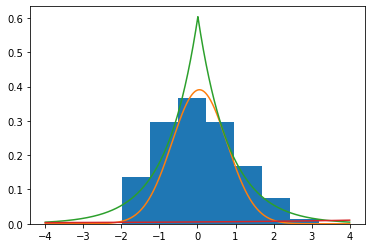

In [10]:
x = np.linspace(-4,4,10000)
mug = np.mean(s)
varg = np.var(s)
yg = GaussDis(x,mug,varg)
mul = np.median(s)
bl = sum(np.abs(s-mul))/len(s)
yl = LaplaceDist(x,mul,bl)
sf = StudentFit(s,x)
ys = sf.StudentDist()

# plot
count, bins, ignored = plt.hist(s, 7, density=True)
plt.plot(x,yg)
plt.plot(x,yl)
plt.plot(x,ys)

#### With outlier

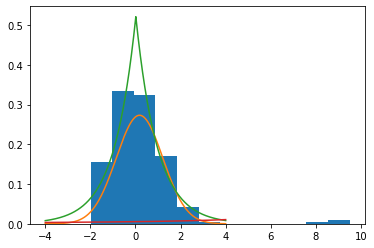

In [8]:
mug = np.mean(sall)
varg = np.var(sall)
yg = GaussDis(x,mug,varg)
mul = np.median(sall)
bl = sum(np.abs(sall-mul))/len(s)
yl = LaplaceDist(x,mul,bl)
sfall = StudentFit(sall,x)
ysall = sf.StudentDist()

# plot
count, bins, ignored = plt.hist(sall, 12, density=True)
plt.plot(x,yg)
plt.plot(x,yl)
plt.plot(x,ysall)